# requirements.txt

In [6]:
!pip install ultralytics
!pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install numpy
!pip install pandas
!pip install Pillow
!pip install pyYAML
!pip install requests
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


# convert coco to yolo

In [2]:
import os
import json

In [3]:
with open("../datasets/sample_dataset/train/_annotations.coco.json", "r") as train_json:
    train_dataset = json.load(train_json)
    train_json.close()

with open("../datasets/sample_dataset/valid/_annotations.coco.json", "r") as valid_json:
    valid_dataset = json.load(valid_json)
    valid_json.close()

with open("../datasets/sample_dataset/test/_annotations.coco.json", "r") as test_json:
    test_dataset = json.load(test_json)
    test_json.close()

In [4]:
def json2yolo(dataset, save_path):
    os.makedirs(save_path, exist_ok=True)

    categories = [category["name"] for category in dataset["categories"]]
    save_categories_name = os.path.join(save_path, "classes.txt")
    lines = ""
    for category in categories:
        lines += f"{category}\n"
    
    with open(save_categories_name, "w") as f:
        f.writelines(lines)
        f.close()

    for img, anno in zip(dataset["images"], dataset["annotations"]):
        lines = ""
        file_name = img["file_name"]
        save_name = os.path.join(save_path, file_name).replace(".jpg", ".txt")
        height = img["height"]
        width = img["width"]
        category = anno["category_id"]
        bbox = anno["bbox"]
        x1, y1, x2, y2 = bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]
        
        x = (x1+x2)/2/width
        y = (y1+y2)/2/height
        w = (x2-x1)/width
        h = (y2-y1)/height
        
        lines += f"{category} {round(x,6)} {round(y,6)} {round(w,6)} {round(h,6)}\n"
        
        with open(save_name, "w") as f:
            f.writelines(lines)
            f.close()

In [5]:
json2yolo(train_dataset, "../datasets/sample_dataset/train/labels")
json2yolo(valid_dataset, "../datasets/sample_dataset/valid/labels")
json2yolo(test_dataset, "../datasets/sample_dataset/test/labels")

# train

In [1]:
from ultralytics import YOLO

c:\Users\jeongjin\anaconda3\envs\rhee_halibut\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# build from YAML and transfer weights
model = YOLO('yolov8s.yaml').load('pretrained/yolov8s.pt')

# Train the model
model.train(cfg="cfg/custom.yaml")


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

# predict

In [32]:
from ultralytics import YOLO
import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2

# model = YOLO(model="runs/sample/weights/best.pt", task="detect")
model = YOLO(model="pretrained/yolov8s.pt", task="detect")

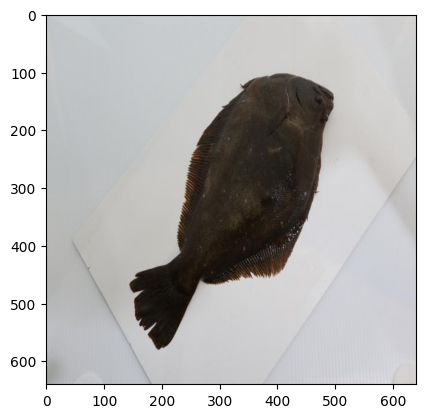

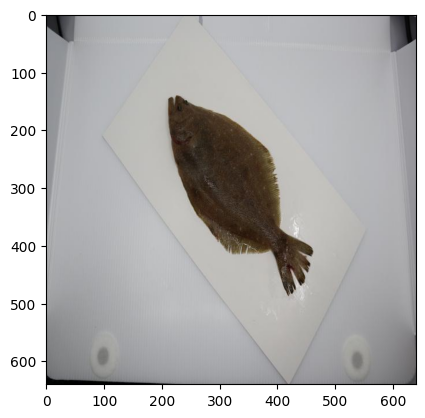

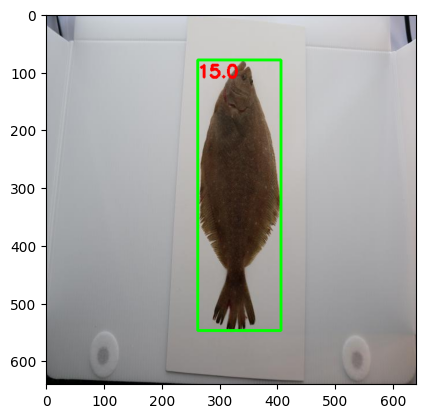

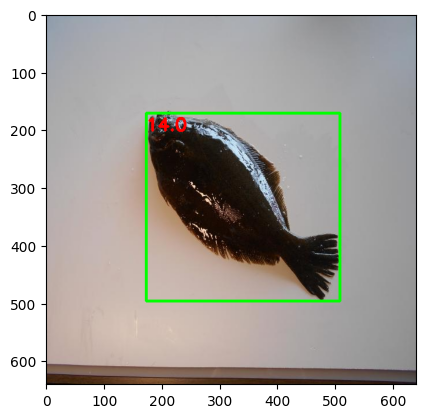

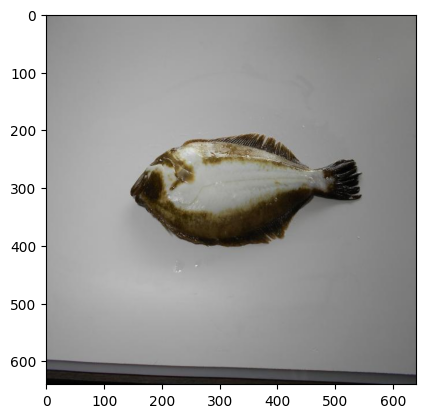

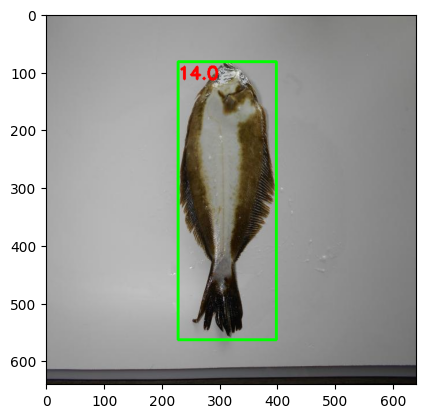

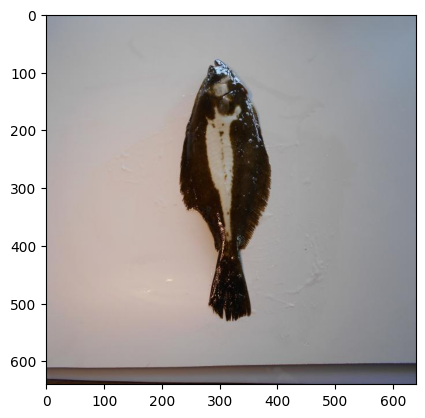

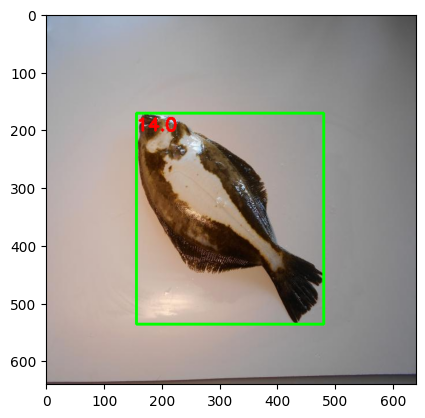

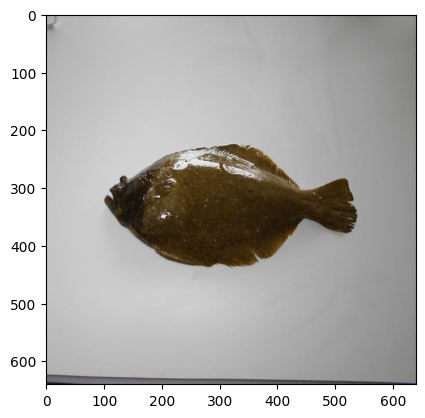

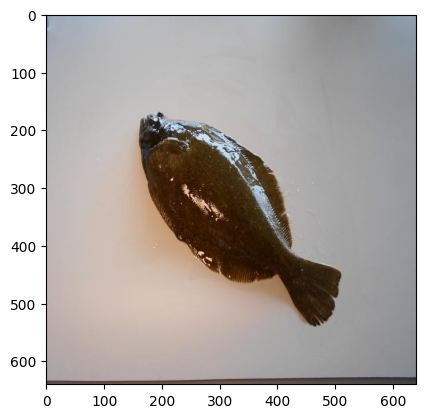

In [35]:
%matplotlib inline
for im_path in glob.glob("../datasets/sample_dataset/test/images/*.jpg"):
    img = cv2.imread(im_path, cv2.IMREAD_COLOR)
    results = model.predict(source=img, verbose=False, iou=0.75, device=0)  # predict on an image
    for result in results:
        score = result.boxes.conf.cpu().numpy()  # 객체 당 score tensor 리스트
        classes = result.boxes.cls.cpu().numpy()  # 객체 당 class 리스트
        xyxy = result.boxes.xyxy.cpu().numpy()  # 객체 당 xyxy 리스트

        for i in range(len(classes)):
            if score[i] >= 0.7:
                x1, y1, x2, y2 = [int(x) for x in xyxy[i]]
                img = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 3)
                img = cv2.putText(img, str(classes[i]), (x1, y1+30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 3)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()